The purpose of this notebook is prototype the code necessary to create the streamflow forecast plot that will be displayed in the UI.

requirements: pandas, matplotlib, tqdm, dataretrieval

In [6]:
#!pip install matplotlib tqdm dataretrieval -q

In [1]:
import creds
from dataretrieval import nwis
from forecast import Forecasts, ForecastTypes
from analysis import AnalysisAssim, Offsets
from datetime import datetime,timedelta


import matplotlib.pyplot as plt
%matplotlib ipympl

In [10]:
fdata = Forecasts(creds.key)

### Inputs from UI

Define a list of reaches for which data will be collected.

In [11]:
# these reaches are near Westphalia, MO (Maries river)
nwm_reach_ids = [
    '5984415',
    '5984419',
    '5984765', # this one is associated with nwis site 06927000 
    '5984441',
    '5985049',
]

# https://nwis.waterdata.usgs.gov/nwis/uv?cb_00060=on&cb_00065=on&format=gif_default&site_no=06927000&legacy=1&period=&begin_date=2024-11-01&end_date=2024-12-31

In [21]:
# Reference time is the time associated with the when
# the forecast was initiatied.
reference_time = datetime(2024,11,4)

# While our code is designed to take multiple reference times, 
# our interface will likely be designed to work with a single
#reference time. 
reference_times = [reference_time.strftime('%Y-%m-%d')]

In [22]:
# collect all the forecast ensembles for the medium prediction.
# Medium-Range Forecast: Six-member ensemble forecasts out to 10 days (member 1) and 8.5 days (members 2-6) initialized by standard analysis and forced by a time-lagged ensemble of GFS data
fdata.collect_forecasts([nwm_reach_ids[2]],
                         ForecastTypes.MEDIUM,
                         reference_times, 
                         ensembles='all',
                         )
medium_df = fdata.df.copy()


# collect all the forecast ensembles for the short prediction.
# Short-Range Forecast: 18-hour deterministic (single value) forecast
fdata.collect_forecasts([nwm_reach_ids[2]],
                         ForecastTypes.SHORT,
                         reference_times, 
                         ensembles='0',
                         )
short_df = fdata.df.copy()

# collect analysis and assimilation data
adata = AnalysisAssim(creds.key)
st = (reference_time - timedelta(days=10)).strftime('%Y-%m-%d')
#et = reference_time.strftime('%Y-%m-%d')
et = (reference_time + timedelta(days=10)).strftime('%Y-%m-%d')
adata.collect_analysis_assim([nwm_reach_ids[2]],
                             st,
                             et,
                             offsets='1')
analysis_df = adata.df.copy()

# Collect NWIS Observed Streamflow
site_no = '06927000'
parameterCode = "00060" 
startDate = (reference_time - timedelta(days=5)).strftime("%Y-%m-%d")
endDate = (reference_time + timedelta(days=10)).strftime("%Y-%m-%d")
nwis_df = nwis.get_dv(sites=site_no, parameterCd=parameterCode, start=startDate, end=endDate)[0]

# NWIS 00060 is CFS. This needs to be converted to CMS for comparison with NWM
nwis_df['streamflow_cms'] = nwis_df['00060_Mean'] / (3.28**3)





Fetching Forecast Data:   0%|                                         | 0/1 [00:00<?, ?url/s]

Fetching Forecast Data:   0%|                                         | 0/1 [00:00<?, ?url/s]

Fetching Analysis and Assimilation Data:   0%|                        | 0/1 [00:00<?, ?url/s]

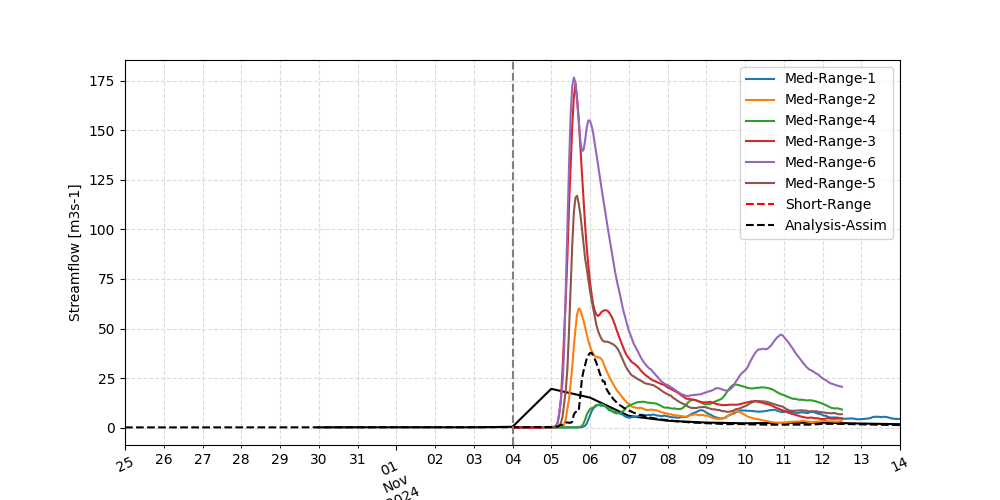

In [23]:
# Create Plots
fig, ax = plt.subplots(figsize=(10, 5))

## NWIS
nwis_df['streamflow_cms'].plot(ax=ax, color='k')

# MEDIUM RANGE
for e in medium_df.ensemble.unique():
    label = f'Med-Range-{int(e)+1}'
    medium_df[medium_df['ensemble'] == e].plot(ax=ax, x='time', y='streamflow', label=label)
    
# SHORT RANGE
short_df.plot(ax=ax, x='time', y='streamflow', color='red', linestyle='--', label='Short-Range')

# ANALYSIS ASSIM
analysis_df.plot(ax=ax, x='time', y='streamflow', color='k', linestyle='--', label='Analysis-Assim')

# STYLING
ax.axvline(x=reference_time, color='grey', linestyle='--')
ax.grid(which='both', axis='both', linestyle='--', color='gainsboro')
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow [m3s-1]')
plt.xticks(rotation=25) 
plt.show()

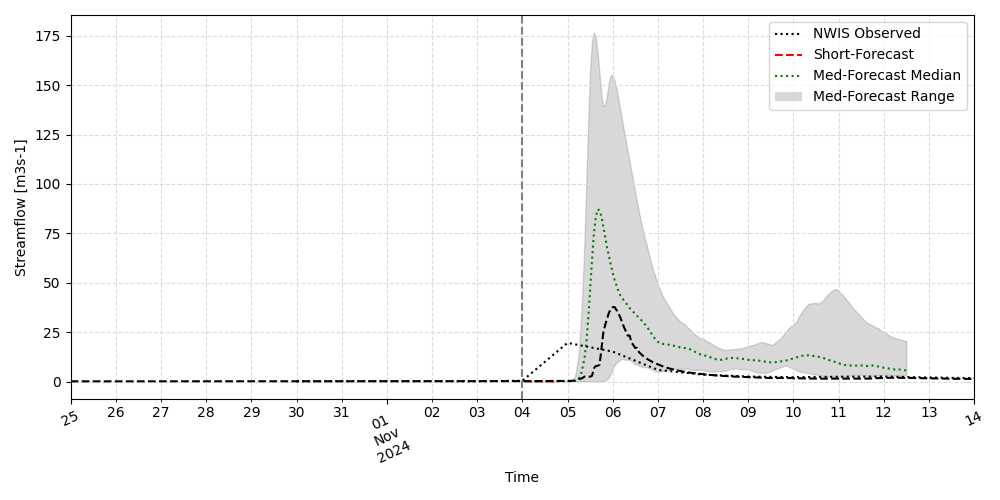

In [25]:
# Create Plots
fig, ax = plt.subplots(figsize=(10, 5))



# MEDIUM RANGE
medium_ranges = medium_df.groupby('time')['streamflow'].agg(['min', 'max', 'median', 'count']).reset_index()
medium_ranges = medium_ranges[medium_ranges['count'] >= 6]  # Omit values with less than 6 entries 
medium_ranges.plot(ax=ax, x='time', y='median', color='green', linestyle='dotted', label='Med-Forecast Median')
ax.fill_between(ax.get_lines()[0].get_xdata(),
                medium_ranges['min'],
                medium_ranges['max'],
                color='grey',
                alpha=0.3)

# NWIS
nwis_df['streamflow_cms'].plot(ax=ax, color='k', linestyle='dotted', label='NWIS Observed')
    
# SHORT RANGE
short_df.plot(ax=ax, x='time', y='streamflow', color='red', linestyle='--', label='Short-Forecast')

# ANALYSIS ASSIM
analysis_df.plot(ax=ax, x='time', y='streamflow', color='k', linestyle='--', label='Analysis-Assim')


# STYLING
ax.axvline(x=reference_time, color='grey', linestyle='--')
ax.grid(which='both', axis='both', linestyle='--', color='gainsboro')
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow [m3s-1]')
plt.xticks(rotation=25) 

# Custom legend to include the shaded area
from matplotlib.patches import Patch
legend_elements = [
    ax.get_lines()[1],  # observed nwis
    ax.get_lines()[2],   # short forecast
    ax.get_lines()[0],  # medium forecast median
    Patch(facecolor='grey', alpha=0.3, label='Med-Forecast Range'), 
]

ax.legend(handles=legend_elements)
plt.tight_layout()
plt.show()